# Data preparation

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
train = pd.read_csv("train.csv", header = 0)
test = pd.read_csv("test.csv", header = 0)

In [2]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Clean the data
From the following analysis we know there is only cabin feature has null values. I will use Imputer to handle those null values.

In [4]:
train.isnull().describe()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891,891,891,891,891,891,891,891,891,891,891,891
unique,1,1,1,1,1,2,1,1,1,1,2,2
top,False,False,False,False,False,False,False,False,False,False,True,False
freq,891,891,891,891,891,714,891,891,891,891,687,889


In [5]:
test.isnull().describe()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418,418,418,418,418,418,418,418,418,418,418
unique,1,1,1,1,2,1,1,1,2,2,1
top,False,False,False,False,False,False,False,False,False,True,False
freq,418,418,418,418,332,418,418,418,417,327,418


In [6]:
from sklearn.impute import SimpleImputer
SI = SimpleImputer(strategy="most_frequent")
train['Cabin'].unique()

#Imputation for Cabin and Embarked
train_impute = pd.DataFrame(SI.fit_transform(train[["Cabin","Embarked"]]))
test_impute = pd.DataFrame(SI.transform(test[["Cabin" ,"Embarked"]]))

train[["Cabin","Embarked"]] = train_impute
test[["Cabin","Embarked"]] = test_impute

#Imputation for age and Fare
SI_num = SimpleImputer(strategy="mean")
train_impute = pd.DataFrame(SI_num.fit_transform(train[["Age","Fare"]]))
test_impute = pd.DataFrame(SI_num.transform(test[["Age" ,"Fare"]]))

train[["Age" ,"Fare"]] = train_impute
test[["Age" ,"Fare"]] = test_impute

# Handle Categorital features

In [7]:
handle_train = train.drop('Survived', axis = 1)
feature_ob = (handle_train.dtypes == object)
feature_ob

PassengerId    False
Pclass         False
Name            True
Sex             True
Age            False
SibSp          False
Parch          False
Ticket          True
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [8]:
# Select types
train_obj = handle_train.iloc[:,feature_ob.values]
test_obj = test.iloc[:,feature_ob.values]

train_obj.describe().loc['unique']

#From the unique value, we can use OneHotEncoder for Sex and Embarked and Label Encoding for Ticket and Cabin

Name        891
Sex           2
Ticket      681
Cabin       147
Embarked      3
Name: unique, dtype: object

# OneHotEncoding

In [22]:
from sklearn.preprocessing import OneHotEncoder
OHE = OneHotEncoder(handle_unknown='ignore', sparse=False)

train_onehot = pd.DataFrame(OHE.fit_transform(handle_train[['Sex']]), columns = OHE.get_feature_names())
test_onehot = pd.DataFrame(OHE.transform(test[['Sex']]), columns = OHE.get_feature_names())

train_new = pd.concat([handle_train.drop(['Sex'], axis = 1), train_onehot], axis = 1)
test_new= pd.concat([test.drop(['Sex'], axis = 1), test_onehot], axis = 1)

In [24]:
train_new[['Ticket']]

,Ticket
0,A/5 21171
1,PC 17599
2,STON/O2. 3101282
3,113803
4,373450
...,...
886,211536
887,112053
888,W./C. 6607
889,111369


# Categorical Encoding

In [49]:
import category_encoders as ce
le = ce.OrdinalEncoder()
train_new[["Ticket",'Cabin', 'Embarked']] =  le.fit_transform(handle_train[["Ticket",'Cabin', 'Embarked']])
test_new[["Ticket",'Cabin', 'Embarked']] =  le.transform(handle_train[["Ticket",'Cabin', 'Embarked']])

# Feature Selection

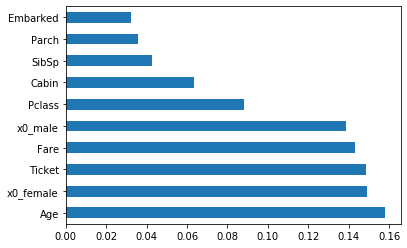

In [50]:
from sklearn.ensemble import ExtraTreesClassifier

X = train_new.drop(['PassengerId','Name'],axis = 1)
y = train.Survived
model = ExtraTreesClassifier()
model.fit(X,y)
#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
features_use = feat_importances.nlargest(10).index
feat_importances.nlargest(10).plot(kind='barh')


# Construct the model (Random Forest)

In [68]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
y = train.Survived
X = train_new[features_use]
for i in np.arange(10,150,10):
    scores = -1 * cross_val_score(RandomForestRegressor(n_estimators=100,random_state=0,
                                                       max_samples = i), X, y,
                                  cv=5,
                                  scoring='neg_mean_absolute_error')
    print((scores.mean()))
    
model_1 = RandomForestRegressor(n_estimators=100,random_state=0, max_samples = 10)
model_1.fit(X,y)
test["Survived"] =  model_1.predict(test_new[features_use])
def fun(x):
    if x >= 0.5:
        return 1
    else:
        return 0


0.37229640323896807
0.3345569644090139
0.3174052476304061
0.3107663046889712
0.3037781683510138
0.3000534492498902
0.29471078400602596
0.29287654049756245
0.28679975100956207
0.28674515096353026
0.2892964032389681
0.28129025171050154
0.28700922729269973
0.28024234720565777


In [73]:
test["Survived"] = test["Survived"].apply(fun)
R = test["Survived"].apply(fun)

In [74]:
submission = test[["PassengerId","Survived"]]
submission.to_csv("sub.csv",index = False)

In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
y = train.Survived
X = train_new[features_use]
for i in np.arange(5,10,1):
    scores = -1 * cross_val_score(RandomForestClassifier(n_estimators=120,random_state=0,
                                                       max_samples = i), X, y,
                                  cv=5,
                                  scoring='neg_mean_absolute_error')
    print((scores.mean()))
    
model_2 = RandomForestClassifier(n_estimators=120,random_state=0, max_samples = 5)
model_2.fit(X,y)
test["Survived"] =  model_2.predict(test_new[features_use])
Q = test.Survived

0.2783001694808863
0.25474232628209154
0.25027932960893856
0.23004833343795114
0.22667754692109723


In [84]:
submission = test[["PassengerId","Survived"]]
submission.to_csv("sub_RFC.csv",index = False)

In [81]:
R[R != Q]

15     1
32     1
33     1
52     1
64     1
      ..
367    1
374    1
391    1
407    1
409    1
Name: Survived, Length: 69, dtype: int64

In [33]:
def convert_R(x):
    if x > 0.5:
        return(1)
    else:
        return(0)
test.Survived = test.Survived.apply(convert_R)

In [34]:
submission = test[["PassengerId","Survived"]]
submission.to_csv("sub_Random-Forest.csv",index = False)

# Solution of Pytorch

In [21]:
train_new.Ticket

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

In [54]:
X = train_new.drop(['PassengerId','Name','Ticket','Embarked'],axis = 1)
X_test = test_new.drop(['PassengerId','Name','Ticket','Embarked'],axis = 1)
y = train.Survived.values

In [24]:
X.shape

(891, 154)

In [138]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(100,30)
        self.fc2 = nn.Linear(30,2)
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = F.sigmoid(x)
        return x
net = Net()

# Optimization

In [139]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)

In [140]:
X_train = train_new[features_use].values
Y_train = train.Survived.values

In [141]:
X_train.shape

(891, 100)

In [142]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.1)

In [143]:
from sklearn.utils import shuffle
from torch.autograd import Variable
batch_size = 140
num_epochs = 80
batch_no = 50
for epoch in range(num_epochs):
    if epoch % 5 == 0:
        print('Epoch {}'.format(epoch+1))
    x_train, y_train = shuffle(x_train, y_train)
    # Mini batch learning
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        x_var = torch.FloatTensor(x_train[start:end])
        y_var = torch.LongTensor(y_train[start:end])
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        ypred_var = net(x_var)
        loss =criterion(ypred_var, y_var)
        loss.backward()
        optimizer.step()
running_loss = 0.0

Epoch 1
Epoch 6


/Users/fatmimi/opt/anaconda3/envs/playground/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 11
Epoch 16
Epoch 21
Epoch 26
Epoch 31
Epoch 36
Epoch 41
Epoch 46
Epoch 51
Epoch 56
Epoch 61
Epoch 66
Epoch 71
Epoch 76


In [144]:
# Evaluate the model
test_var = torch.Tensor(x_val)
with torch.no_grad():
    result = net(test_var)
values, labels = torch.max(result, 1)
num_right = np.sum(labels.data.numpy() == y_val)
print('Accuracy {:.2f}'.format(num_right / len(y_val)))

Accuracy 0.28


# Prediction

In [93]:
with torch.no_grad():
    X_test_var = Variable(torch.FloatTensor(X_test.values), requires_grad=True)
    test_result = net(X_test_var)

In [106]:
values_, labels_ = torch.max(test_result, 1)

In [108]:
len(labels_)

418

In [114]:
test["Survived"] = labels_
submission = test[["PassengerId","Survived"]]
submission.to_csv("sub_Random-torch.csv",index = False)
